In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

In [3]:
path = 'data/kaari2132023.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

raw = pd.read_csv(path, dtype=dtypes)

raw['datetime'] = pd.to_datetime(raw['datetime'])

In [4]:
MIN_ELEVATION = 20

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
data = data.loc[data['elm'] > MIN_ELEVATION]
data = data[(data['datetime'].dt.hour >= 6) & (data['datetime'].dt.hour < 18)]

C:\Users\virtanem\AppData\Local\Temp\ipykernel_9096\460248443.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


In [5]:
df = data.groupby('datetime').filter(lambda x: len(x) >= 1000)
print(len(df['datetime'].unique()), len(data['datetime'].unique()))
frames = sorted(df['datetime'].unique())

1120 1440


In [9]:
df0 = data.groupby('datetime').filter(lambda x: len(x) <= 1000)
print(len(df0['datetime'].unique()), len(data['datetime'].unique()))
blips = sorted(df0['datetime'].unique())
blip_sites = df0['gps_site'].unique().tolist()
print(blip_sites)

320 1440
["b'ajoe'", "b'kosi'", "b'kusa'", "b'mus2'", "b'njoe'", "b'pyrk'", "b'rall'", "b'sur4'", "b'tarv'", "b'toil'", "b'verg'"]


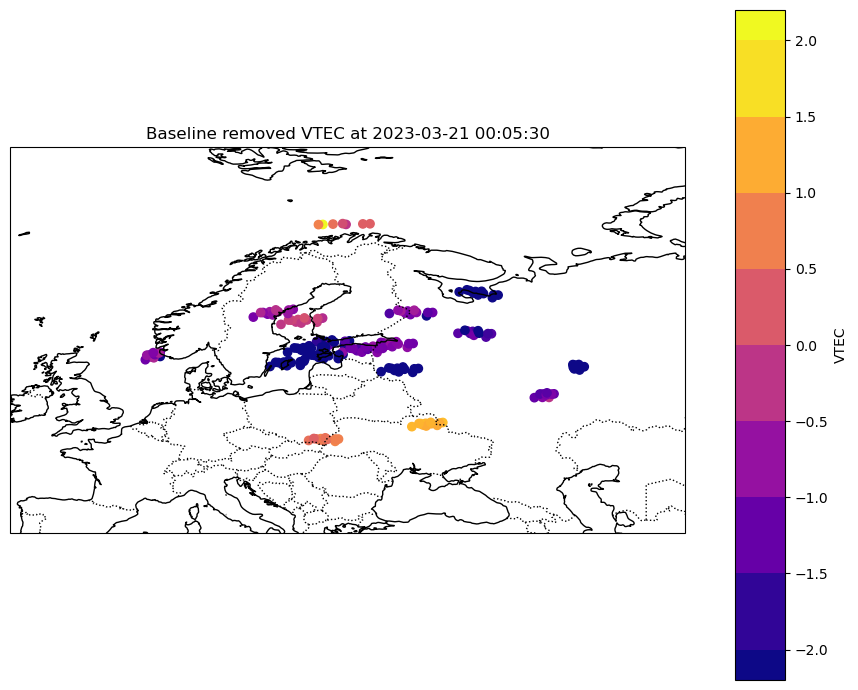

In [4]:
def create_fig_s(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

def show_fig(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_s(fig, ax, datetime, df, RES)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig(frames[11], df, RES=0.5)

MovieWriter imagemagick unavailable; using Pillow instead.


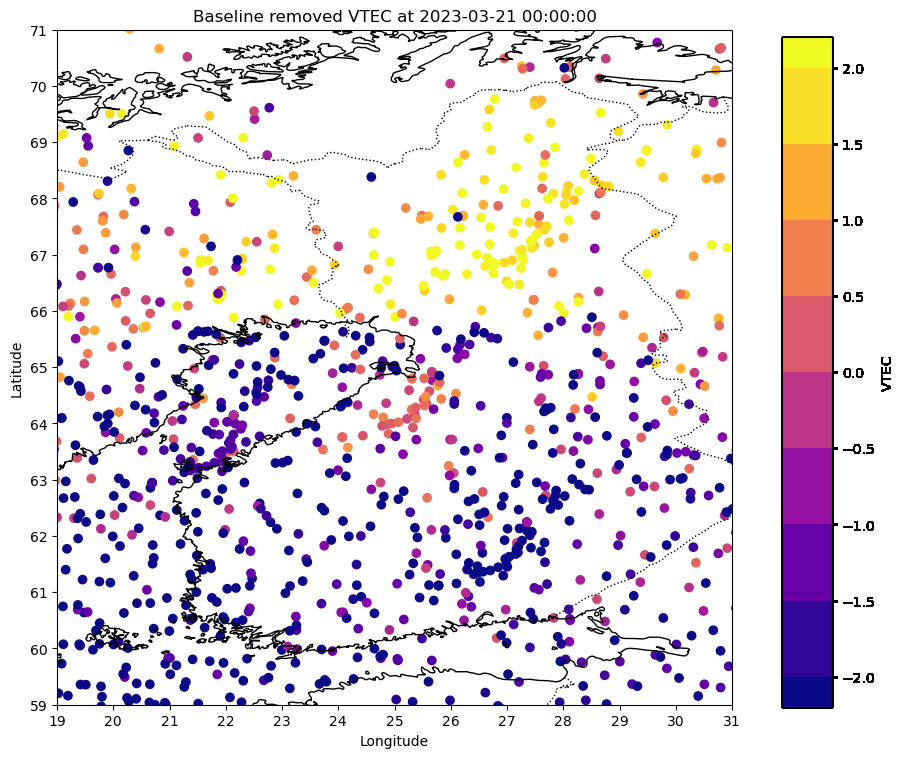

In [6]:
def update(frame):
    df1 = df.loc[df['datetime'] == frame]
    ax.clear()

    ax.set_xlim(19, 31)
    ax.set_ylim(59,71)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed VTEC at {frame}')
    plot = ax.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both', 
                        mappable=plot
                        )
    
    fig.canvas.draw()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

animation = FuncAnimation(fig, update, frames=frames[0:100], interval=100)

animation.save('heatmap_animation.gif', writer='imagemagick')
# animation.save('animations/heatmap_animation_sg.mp4', writer='ffmpeg')